# Data exploration - dataset 2

Process notebook for TPP08

Author: Ziyang Lin (zlin4387)

Date: 20/09/2022

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

We load the data we're interested in, and then create a copy if it so we can perform data cleaning without modifying the raw data.

In [43]:
dataset_path = Path('../../datasets')
raw_data_p2 = pd.read_csv(dataset_path / 'Participant-02-detail.csv')
data_p2 = raw_data_p2.copy()
raw_data_p2.head()

,Source,Date,Hour,Count
0,P2 Phone,2022-01-01,5,31
1,P2’s Apple Watch,2021-12-31,21,20
2,P2’s Apple Watch,2021-12-31,21,16
3,P2’s Apple Watch,2022-01-01,5,29
4,P2’s Apple Watch,2022-01-01,5,13


We can see from the above that the dataset contains hourly step count collected from various sources (mobile phone and smartwatch).

## Data cleaning

The code below displays the sources (devices that Participant 02 uses) in the data and the corresponding number of rows.

In [44]:
data_p2.groupby('Source').size()

Source
P2 Phone             8190
P2’s Apple Watch    23447
P2’s iPhone             1
dtype: int64

We can see that there are two souces that both mean the smartphone. We can merge them into one category and convert the column from string to a categorical variable.

In [45]:
def convert_source(s):
    if s.find('Phone') >= 0:
        return 'Phone'
    if s.find('Watch') >= 0:
        return 'Smartwatch'
    return None
data_p2['SourceCat'] = data_p2['Source'].map(convert_source).astype('category')
data_p2.groupby('SourceCat').size()

SourceCat
Phone          8191
Smartwatch    23447
dtype: int64

Next, because the `Date` column is a string like "2022-01-01", we need to convert it to three columns `Year`, `Month`, and `Day` to make it more useful for data analysis.

In [46]:
data_p2[['Year', 'Month', 'Day']] = data_p2['Date'].str.split('-', 2, expand=True).astype('int')
data_p2.head()

,Source,Date,Hour,Count,SourceCat,Year,Month,Day
0,P2 Phone,2022-01-01,5,31,Phone,2022,1,1
1,P2’s Apple Watch,2021-12-31,21,20,Smartwatch,2021,12,31
2,P2’s Apple Watch,2021-12-31,21,16,Smartwatch,2021,12,31
3,P2’s Apple Watch,2022-01-01,5,29,Smartwatch,2022,1,1
4,P2’s Apple Watch,2022-01-01,5,13,Smartwatch,2022,1,1


Because we will look at the weekly step count patterns, it is also helpful to include weekday in the cleaned dataset.

In [47]:
data_p2['Timestamp'] = pd.to_datetime(data_p2[['Year', 'Month', 'Day', 'Hour']])
data_p2['Weekday'] = data_p2['Timestamp'].dt.weekday

cleaned_p2 = data_p2[['SourceCat', 'Timestamp', 'Weekday', 'Year', 'Month', 'Day', 'Hour', 'Count']]
cleaned_p2.head()

,SourceCat,Timestamp,Weekday,Year,Month,Day,Hour,Count
0,Phone,2022-01-01 05:00:00,5,2022,1,1,5,31
1,Smartwatch,2021-12-31 21:00:00,4,2021,12,31,21,20
2,Smartwatch,2021-12-31 21:00:00,4,2021,12,31,21,16
3,Smartwatch,2022-01-01 05:00:00,5,2022,1,1,5,29
4,Smartwatch,2022-01-01 05:00:00,5,2022,1,1,5,13


Note that the `Weekday` column assigns Monday as 0 and Sunday as 6.

In [48]:
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

One problem with the data is that the activity from the same day can be twice by both the phone and the smartwatch. As the smartwatch data point is more accurate, we will mainly focus on data from the smartwatch.

In [49]:
smartwatch_data = cleaned_p2[cleaned_p2['SourceCat'] == 'Smartwatch']
smartwatch_data.head()

,SourceCat,Timestamp,Weekday,Year,Month,Day,Hour,Count
1,Smartwatch,2021-12-31 21:00:00,4,2021,12,31,21,20
2,Smartwatch,2021-12-31 21:00:00,4,2021,12,31,21,16
3,Smartwatch,2022-01-01 05:00:00,5,2022,1,1,5,29
4,Smartwatch,2022-01-01 05:00:00,5,2022,1,1,5,13
7,Smartwatch,2022-01-01 05:00:00,5,2022,1,1,5,19


## Exploration

We would like to know the weekly patterns, so it is helpful to create boxplots for each weekday and compute the daily averages.

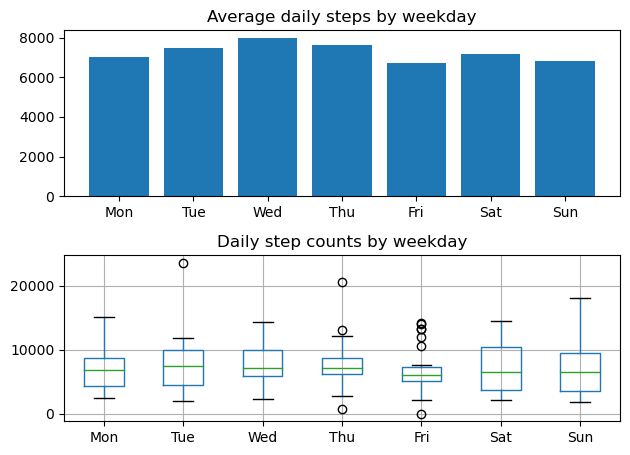

In [50]:
daily_sums = smartwatch_data.groupby(['Year', 'Month', 'Day', 'Weekday'], as_index=False)['Count'].sum()
# daily_sums['WeekdayStr'] = daily_sums['Weekday'].map(lambda x : weekdays[x])
weekday_avgs = daily_sums.groupby('Weekday')['Count'].agg(np.average)

fig, axs = plt.subplots(2, 1)
axs[0].bar(weekdays, weekday_avgs)
axs[0].set_title('Average daily steps by weekday')

daily_sums.boxplot(column='Count', by='Weekday', ax=axs[1])
axs[1].set_title('Daily step counts by weekday')
axs[1].set_xticks(np.arange(7) + 1, labels=weekdays)
axs[1].set_xlabel(None)

fig.suptitle('')
fig.tight_layout()
plt.show()


From the plots we can see that the participant is most active on Wednesdays on average, and least active on Fridays with lowest mean and median daily steps.

Using 7,500 [1] and 10,000 days [2] as indicators, we plot the proportion of days where the participant reaches the goal.

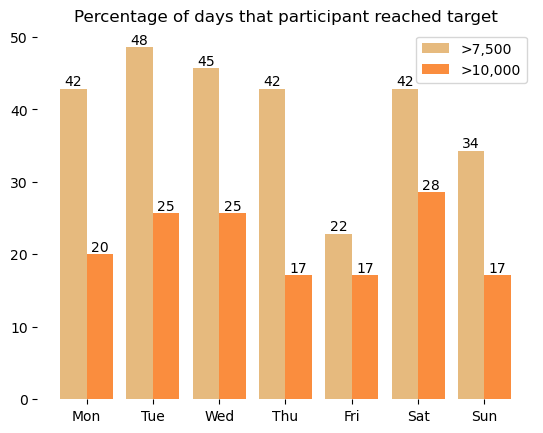

In [51]:
num_weekday_days = daily_sums.groupby('Weekday').size()
p_days_7500 = daily_sums[daily_sums['Count'] > 7500].groupby('Weekday').size() / num_weekday_days * 100
p_days_10000 = daily_sums[daily_sums['Count'] > 10000].groupby('Weekday').size() / num_weekday_days * 100

x = np.arange(7)
width = 0.4

fig, ax = plt.subplots()

bar_7500 = ax.bar(x - width / 2, p_days_7500, width=width, color='#E6BA7E', label='>7,500')
ax.bar_label(bar_7500, fmt='%d')
bar_10000 = ax.bar(x + width / 2, p_days_10000, width=width, color='#FA8D3E', label='>10,000')
ax.bar_label(bar_10000, fmt='%d')

ax.set(frame_on=False)
plt.title('Percentage of days that participant reached target')
plt.xticks(x, labels=weekdays)
plt.legend()
plt.show()

The plot agrees with previous statistics. We can see that the participant usually walks more on Tuesdays, Wednesdays, and Saturdays. Friday is the overall least active day. 

## References

[1] A. E. Paluch et al., “Daily steps and all-cause mortality: a meta-analysis of 15 international cohorts,” The Lancet Public Health, vol. 7, no. 3, pp. e219–e228, Mar. 2022, doi: 10.1016/S2468-2667(21)00302-9.

[2] Anthony L. Komaroff, “How many steps should I take each day? - Harvard Health.” https://www.health.harvard.edu/staying-healthy/how-many-steps-should-i-take-each-day (accessed Sep. 20, 2022).

